# Basic data description using BigQuery
* This notebook shows execution of basic SQL queries along with simple visualizations.
* There will be used San Francisco Bikeshares dataset. It contains information about trips for the bikeshare program in San Francisco

# Import libraries and conect to googl cloud

In [61]:
# relevant installs
#!pip install google-cloud 
#!pip install --upgrade google-cloud-bigquery[pandas] 
#!pip install google-cloud-storage

In [3]:
import subprocess
import sys
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [4]:
%matplotlib inline

In [15]:
from google.cloud import bigquery
from google.colab import auth

auth.authenticate_user()
client = bigquery.Client(project='uplifted-block-335620')

In [ ]:
def query_to_df(query):
    # transfers query results to pandas dataframe for easy manipulating
    return(client.query(query).result().to_dataframe())

def get_schema(table):
    # retreives the schema as a printed object
    return(client.get_table(table).schema)

# Get tables schemes

In [8]:
table = 'bigquery-public-data.san_francisco_bikeshare.bikeshare_regions'
get_schema(table)

[SchemaField('region_id', 'INTEGER', 'REQUIRED', None, 'Unique identifier for the region', (), None),
 SchemaField('name', 'STRING', 'REQUIRED', None, 'Public name for this region', (), None)]

In [9]:
#bikeshare_station_info
table = 'bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info'
get_schema(table)

[SchemaField('station_id', 'STRING', 'REQUIRED', None, 'Unique identifier of a station.', (), None),
 SchemaField('name', 'STRING', 'REQUIRED', None, 'Public name of the station', (), None),
 SchemaField('short_name', 'STRING', 'NULLABLE', None, 'Short name or other type of identifier, as used by the data publisher', (), None),
 SchemaField('lat', 'FLOAT', 'REQUIRED', None, 'The latitude of station. The field value must be a valid WGS 84 latitude in decimal degrees format. See: http://en.wikipedia.org/wiki/World_Geodetic_System, https://en.wikipedia.org/wiki/Decimal_degrees', (), None),
 SchemaField('lon', 'FLOAT', 'REQUIRED', None, 'The longitude of station. The field value must be a valid WGS 84 longitude in decimal degrees format. See: http://en.wikipedia.org/wiki/World_Geodetic_System, https://en.wikipedia.org/wiki/Decimal_degrees', (), None),
 SchemaField('region_id', 'INTEGER', 'NULLABLE', None, 'ID of the region where station is located', (), None),
 SchemaField('rental_methods'

In [10]:
#bikeshare_station_status
table = 'bigquery-public-data.san_francisco_bikeshare.bikeshare_station_status'
get_schema(table)

[SchemaField('station_id', 'STRING', 'REQUIRED', None, 'Unique identifier of a station', (), None),
 SchemaField('num_bikes_available', 'INTEGER', 'REQUIRED', None, 'Number of bikes available for rental', (), None),
 SchemaField('num_bikes_disabled', 'INTEGER', 'NULLABLE', None, 'Number of disabled bikes at the station. Vendors who do not want to publicize the number of disabled bikes or docks in their system can opt to omit station capacity (in station_information), num_bikes_disabled and num_docks_disabled. If station capacity is published then broken docks/bikes can be inferred (though not specifically whether the decreased capacity is a broken bike or dock)', (), None),
 SchemaField('num_docks_available', 'INTEGER', 'REQUIRED', None, 'Number of docks accepting bike returns', (), None),
 SchemaField('num_docks_disabled', 'INTEGER', 'NULLABLE', None, 'Number of empty but disabled dock points at the station. This value remains as part of the spec as it is possibly useful during develo

In [11]:
#bikeshare_trips
table = 'bigquery-public-data.san_francisco_bikeshare.bikeshare_trips'
get_schema(table)

[SchemaField('trip_id', 'STRING', 'REQUIRED', None, 'Numeric ID of bike trip', (), None),
 SchemaField('duration_sec', 'INTEGER', 'NULLABLE', None, 'Time of trip in seconds', (), None),
 SchemaField('start_date', 'TIMESTAMP', 'NULLABLE', None, 'Start date of trip with date and time, in PST', (), None),
 SchemaField('start_station_name', 'STRING', 'NULLABLE', None, 'Station name of start station', (), None),
 SchemaField('start_station_id', 'INTEGER', 'NULLABLE', None, 'Numeric reference for start station', (), None),
 SchemaField('end_date', 'TIMESTAMP', 'NULLABLE', None, 'End date of trip with date and time, in PST', (), None),
 SchemaField('end_station_name', 'STRING', 'NULLABLE', None, 'Station name for end station', (), None),
 SchemaField('end_station_id', 'INTEGER', 'NULLABLE', None, 'Numeric reference for end station', (), None),
 SchemaField('bike_number', 'INTEGER', 'NULLABLE', None, 'ID of bike used', (), None),
 SchemaField('zip_code', 'STRING', 'NULLABLE', None, 'Home zip c

# Which bikes have been used the most?

Text(0.5, 1.0, 'Number of rides per bike')

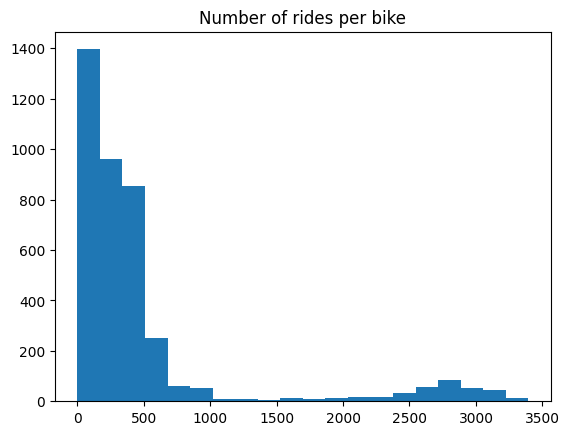

In [18]:
# which bikes have been used the most?
q1 = (
    '''
    SELECT
        COUNT(trip_id) AS num_trips, bike_number 
    FROM
      `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    GROUP BY
      bike_number
    ORDER BY
      num_trips DESC
    ''')


ret_df = client.query(q1).to_dataframe()
plt.hist(ret_df.num_trips, bins = 20)
plt.title("Number of rides per bike")

So here we see that the distribution is not normal, and looks like there's two different fundamental groups that we're dealing with. We have one group of bikes that is used less than about 1000 times, and another normal-ish looking distribution centered around 2750. It might be interesting to look at the differences between these two groups.

# Compare average ride times for bikes above/below 1500 bikes

Text(0, 0.5, 'Density/Frequency')

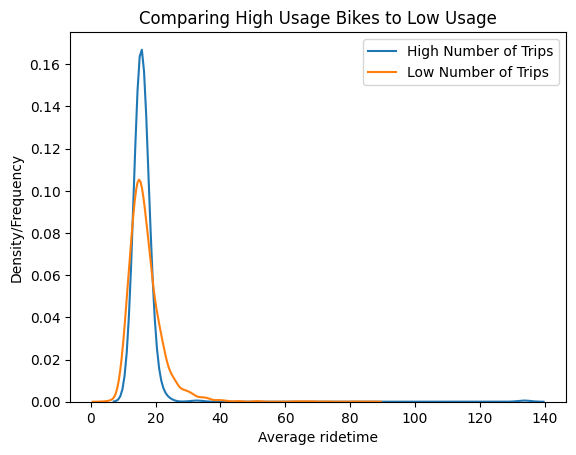

In [34]:
# q2
# compare average ride times for bikes above/below 1500 bikes

# high rides query
q2_a = (
    """
    SELECT
        avg(duration_sec)/60 AS avg_trip_length_min, 
        COUNT(trip_id) AS num_trips,
        bike_number 
    FROM
        `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    GROUP BY
        bike_number
    HAVING
        num_trips >= 1500
    """)

ret_df_a = query_to_df(q2_a)

# low rides query
q2_b = (
    """
    SELECT
        avg(duration_sec)/60 AS avg_trip_length_min,
        COUNT(trip_id) AS num_trips,
        bike_number
    FROM
        `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    GROUP BY
        bike_number
    HAVING
        num_trips < 1500
    """)

ret_df_b = query_to_df(q2_b)

# plot them on the same plot with density lines rather than histograms
sns.kdeplot(ret_df_a['avg_trip_length_min'], 
            label = "High Number of Trips")
sns.kdeplot(ret_df_b['avg_trip_length_min'],
            label = "Low Number of Trips")
plt.legend(prop={'size':10})
plt.title("Comparing High Usage Bikes to Low Usage")
plt.xlabel("Average ridetime")
plt.ylabel("Density/Frequency")

We'll start off by looking at the differences between the average ride time between the many-rides group and the few-rides group.

So we can see that our bikes with lower number of trips have a higher variance around the average trip length, whereas the high usage bikes have much lower variance. Maybe the higher usage bikes are going on certain popular routes.

In [36]:
# high usage
print("high usage")
print(ret_df_a.describe())
print("\n")
print(ret_df_b.describe())

high usage
       avg_trip_length_min    num_trips  bike_number
count           358.000000        358.0        358.0
mean             16.171573  2665.843575   438.709497
std               6.458860   408.998569   139.299144
min              13.069868       1517.0         16.0
25%              14.866111      2469.75       349.25
50%              15.545687       2754.0        447.5
75%              16.481781       2947.0        545.5
max             133.671334       3394.0        878.0


       avg_trip_length_min   num_trips  bike_number
count          3594.000000      3594.0       3594.0
mean             16.913051  276.306344  2152.675849
std               5.593865  205.036652  1090.074206
min               3.858333         1.0          9.0
25%              13.594331      114.25      1276.25
50%              15.837713       230.5       2175.5
75%              18.869190       416.0      3076.75
max              86.211910      1471.0       4073.0


There are some basic statistics aboves. It confirms what we saw on the density plots. Also we can see that there are about 10 times more bikes in low usage group than in high usage group.

It might be ineresting to further investigate the differences between  these 2 goups

# Subscriber vs customers

Other distinct groups are Subscribers and customers (Subscriber = annual or 30-day member; Customer = 24-hour or 3-day member)

Let's look at some differences:

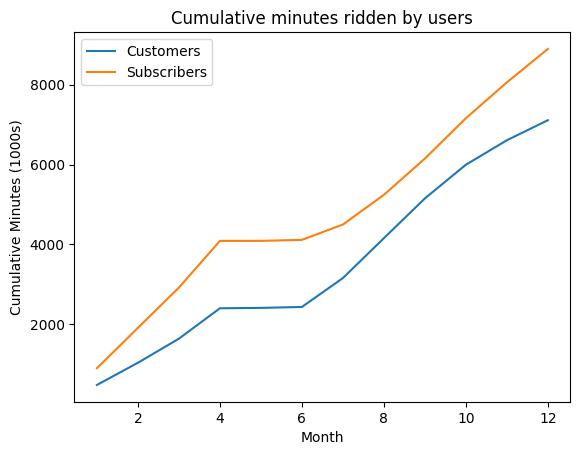

In [50]:
q3 = '''
SELECT
  SUM(customer_minutes_sum) OVER (ORDER BY end_month ROWS UNBOUNDED PRECEDING)/1000 as cumulative_minutes_cust,
  SUM(subscriber_minutes_sum) OVER (ORDER BY end_month ROWS UNBOUNDED PRECEDING)/1000 as cumulative_minutes_sub,
  end_month
FROM
  (
  SELECT
    SUM(CASE WHEN subscriber_type = 'Customer' THEN duration_sec/60 ELSE NULL END) AS customer_minutes_sum,
    SUM(CASE WHEN subscriber_type = 'Subscriber' THEN duration_sec/60 ELSE NULL END) AS subscriber_minutes_sum,
    EXTRACT(MONTH FROM end_date) AS end_month
  FROM
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
  GROUP BY
    end_month
  )
ORDER BY
  end_month
'''
df3 = query_to_df(q3)
plt.plot(df3.end_month, df3.cumulative_minutes_cust, label = "Customers")
plt.plot(df3.end_month, df3.cumulative_minutes_sub, label = "Subscribers")
plt.title("Cumulative minutes ridden by users")
plt.xlabel("Month")
plt.ylabel("Cumulative Minutes (1000s)")
plt.legend()

Data for subscriber type are only available between June 2017 and end of May 2018. We can see bellow that there are lot of data missing in May and June. Anyway, if we don't take in consideration May and June, we can see that:
 * Subscribers are using bikes consistantly throughout the year (The cumulative time of usage have linear trend).
 * We can clearly see that the group of customers is using bikes less in winter. It is indicated by the trend that is slowing down from the 10th month.

In [53]:
q4 = '''
  SELECT
    subscriber_type,
    Count(*) AS count
  FROM
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
  WHERE EXTRACT(MONTH FROM end_date) IN (5,6)
  GROUP BY subscriber_type

'''
df4 = query_to_df(q4)
df4

,subscriber_type,count
0,nan,178040
1,Subscriber,2241
2,Customer,459


Now let's compare average ride duration.

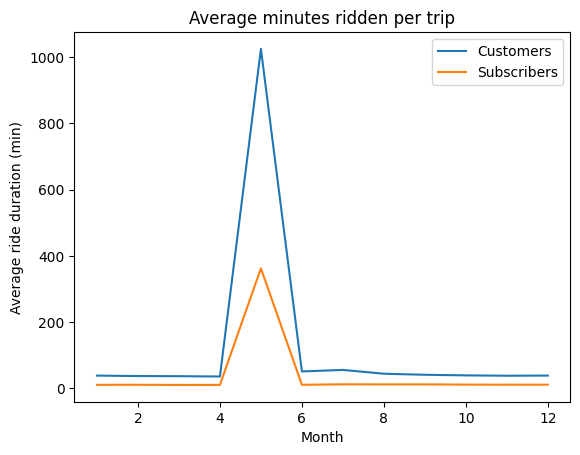

In [63]:
q5 = '''
  SELECT
    AVG(CASE WHEN subscriber_type = 'Customer' THEN duration_sec/60 ELSE NULL END) AS customer_minutes_avg,
    AVG(CASE WHEN subscriber_type = 'Subscriber' THEN duration_sec/60 ELSE NULL END) AS subscriber_minutes_avg,
    EXTRACT(MONTH FROM end_date) AS end_month
  FROM
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
  GROUP BY
    end_month
  ORDER BY
    end_month
'''

df5 = query_to_df(q5)
plt.plot(df5.end_month, df5.customer_minutes_avg, label = "Customers")
plt.plot(df5.end_month, df5.subscriber_minutes_avg, label = "Subscribers")
plt.title("Average minutes ridden per trip")
plt.xlabel("Month")
plt.ylabel("Average ride duration (min)")
plt.legend()

The picture above shows that there is a spike in May. But it might be due to the missing data. We can see that the average ride duration is longer for all months in the customers group. Considering just customer group the average duration is little bit longer in summer than in winter.